In [170]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
"""
    Loads sales data from text file
"""
def load_sales_data():
    df = pd.read_csv(
    'purchases.txt',
    header=None,sep='\t',
    parse_dates=[2],
    names=['customer_id','purchase_amount','date_of_purchase'])
    df['year_of_purchase'] = df.date_of_purchase.dt.year
    return df

"""
    Creates a retrospective snapshot of the sales data as of a given date in the past
"""
def retro(sales_data,retrospective_date):
    retro_date = pd.to_datetime(retrospective_date)
    retro_sales_data = sales_data[sales_data.date_of_purchase < retro_date].copy()
    retro_sales_data['days_since'] = (retro_date - retro_sales_data.date_of_purchase).dt.days
    return retro_sales_data

"""
    Calculate per customer RFM (recency, frequency, money) statistics
"""
def rfm(sales_df,year=None):
    g = sales_df.groupby(by='customer_id')
    df = pd.DataFrame({
        'recency' : g.days_since.min(), 
        'first_purchase' : g.days_since.max(),
        'frequency' : g.days_since.count(), 
        'avg_amount' : g.purchase_amount.mean(),
        'max_amount' : g.purchase_amount.max()}, 
        columns= ['recency','first_purchase','frequency','avg_amount','max_amount'])
    if year:
        df['year'] = year
    return df
"""
    Create a panel of of per customer RFM (recency, frequency, money) statistic per year
"""
def rfm_panel(sales_df):
    retrospective_dates = pd.to_datetime(np.sort(sales_df.date_of_purchase.dt.year.unique()) + 1,format='%Y')
    customers = pd.concat([rfm(retro(sales_df,date),date.year -1) for date in retrospective_dates])
    customers.set_index('year',append=True,inplace=True)
    customers.sort_index(inplace=True)
    return customers

"""
    Segment customers based upon RFM statistics
"""
def segment(customers):
    customers['segment'] = 'NA'
    # segment by recency
    customers.loc[customers.recency > 365*3,'segment'] = 'inactive'
    customers.loc[(customers.recency <= 365*3) & (customers.recency > 365*2),'segment'] = 'cold'
    customers.loc[(customers.recency <= 365*2) & (customers.recency > 365*1),'segment'] = 'warm'
    customers.loc[customers.recency <= 365*1,'segment'] = 'active'
    # segment warm into (new, low value, high value)
    customers.loc[(customers.segment == 'warm') & (customers.first_purchase <= 365*2),'segment'] = 'new warm'
    customers.loc[(customers.segment == 'warm') & (customers.avg_amount < 100),'segment'] = 'warm low value'
    customers.loc[(customers.segment == 'warm') & (customers.avg_amount >= 100),'segment'] = 'warm high value'
    # segment active into (new, low value, high value)
    customers.loc[(customers.segment == 'active') & (customers.first_purchase <= 365),'segment'] = 'new active'
    customers.loc[(customers.segment == 'active') & (customers.avg_amount < 100),'segment'] = 'active low value'
    customers.loc[(customers.segment == 'active') & (customers.avg_amount >= 100),'segment'] = 'active high value'
    customers.segment = order_segments(customers.segment)
    customers.segment.fillna(np.NAN)
    return customers

def order_segments(s):
    return s.astype("category", categories=[
        "inactive",
        "cold",
        "warm high value", "warm low value","new warm",
        "active high value", "active low value", "new active"
        ],ordered=True)


# Load and Prepare RFM Panel

In [12]:
sales_df = load_sales_data()
customers = segment(rfm_panel(sales_df))
customers.head(22)

recency  first_purchase  frequency  avg_amount  max_amount  \
customer_id year                                                               
10          2005      177             177          1   30.000000        30.0   
            2006      542             542          1   30.000000        30.0   
            2007      907             907          1   30.000000        30.0   
            2008     1273            1273          1   30.000000        30.0   
            2009     1638            1638          1   30.000000        30.0   
            2010     2003            2003          1   30.000000        30.0   
            2011     2368            2368          1   30.000000        30.0   
            2012     2734            2734          1   30.000000        30.0   
            2013     3099            3099          1   30.000000        30.0   
            2014     3464            3464          1   30.000000        30.0   
            2015     3829            3829          1   30.000000        30.0   
80          2005       99              99          1   50.000000        50.0   
            2006      464             464          1   50.000000        50.0   
            2007      258             829          2   55.000000        60.0   
            2008      624            1195          2   55.000000        60.0   
            2009      266            1560          3   60.000000        70.0   
            2010      631            1925          3   60.000000        70.0   
            2011      149            2290          4   65.000000        80.0   
            2012      515            2656          4   65.000000        80.0   
            2013      147            3021          5   68.000000        80.0   
            2014      302            3386          6   70.000000        80.0   
            2015      343            3751          7   71.428571        80.0   

                           segment  
customer_id year                    
10          2005        new active  
            2006          new warm  
            2007              cold  
            2008          inactive  
            2009          inactive  
            2010          inactive  
            2011          inactive  
            2012          inactive  
            2013          inactive  
            2014          inactive  
            2015          inactive  
80          2005        new active  
            2006          new warm  
            2007  active low value  
            2008    warm low value  
            2009  active low value  
            2010    warm low value  
            2011  active low value  
            2012    warm low value  
            2013  active low value  
            2014  active low value  
            2015  active low value

# Compute Transition Matrix

In [50]:
segmentation_by_year = customers.segment.unstack('year')
cust_segs_2014 = segmentation_by_year[2014]
cust_segs_2015 = segmentation_by_year[2015]
pd.crosstab(index=cust_segs_2014,columns=cust_segs_2015,margins=False)

2015,inactive,cold,warm high value,warm low value,new warm,active high value,active low value,new active
2014,,,,,,,,
inactive,7227,0,0,0,0,35,250,0
cold,1931,0,0,0,0,22,200,0
warm high value,0,75,0,0,0,35,1,0
warm low value,0,689,0,0,0,1,266,0
new warm,0,1139,0,0,0,15,96,0
active high value,0,0,119,0,0,354,2,0
active low value,0,0,0,901,0,22,2088,0
new active,0,0,0,0,938,89,410,0


In [51]:
transition = pd.crosstab(index=cust_segs_2014,columns=cust_segs_2015,normalize='index',margins=False)
transition

2015,inactive,cold,warm high value,warm low value,new warm,active high value,active low value,new active
2014,,,,,,,,
inactive,0.962061,0.000000,0.000000,0.000000,0.000000,0.004659,0.033280,0.0
cold,0.896888,0.000000,0.000000,0.000000,0.000000,0.010218,0.092894,0.0
warm high value,0.000000,0.675676,0.000000,0.000000,0.000000,0.315315,0.009009,0.0
warm low value,0.000000,0.720711,0.000000,0.000000,0.000000,0.001046,0.278243,0.0
new warm,0.000000,0.911200,0.000000,0.000000,0.000000,0.012000,0.076800,0.0
active high value,0.000000,0.000000,0.250526,0.000000,0.000000,0.745263,0.004211,0.0
active low value,0.000000,0.000000,0.000000,0.299236,0.000000,0.007307,0.693457,0.0
new active,0.000000,0.000000,0.000000,0.000000,0.652749,0.061935,0.285317,0.0


# Compute How Customers Evolve Using Transition Matrix

In [155]:
A = transition.as_matrix().T
years = np.arange(2015,2026)
segments = pd.DataFrame(index=x.index,columns=years)
segments[years[0]] = customers.segment.xs(years[0],level='year').value_counts().sort_index()
for year in years[1:]:
    segments[year] = A.dot(segments[year - 1])
segments = np.round(segments).astype(int)
segments

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
inactive,9158,10517,11539,12636,12940,13186,13386,13542,13664,13759,13834
cold,1903,1584,1711,874,821,782,740,709,684,665,650
warm high value,119,144,165,160,156,152,149,146,143,141,139
warm low value,901,991,1058,989,938,884,844,813,789,771,756
new warm,938,987,0,0,0,0,0,0,0,0,0
active high value,573,657,639,624,607,593,581,571,562,554,547
active low value,3313,3537,3305,3134,2954,2820,2717,2637,2575,2527,2490
new active,1512,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>


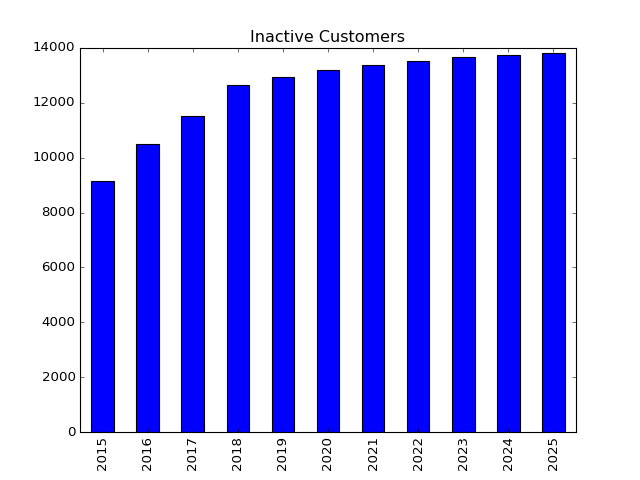

In [175]:
segments.loc['inactive',:].plot.bar(title="Inactive Customers")

<IPython.core.display.Javascript object>


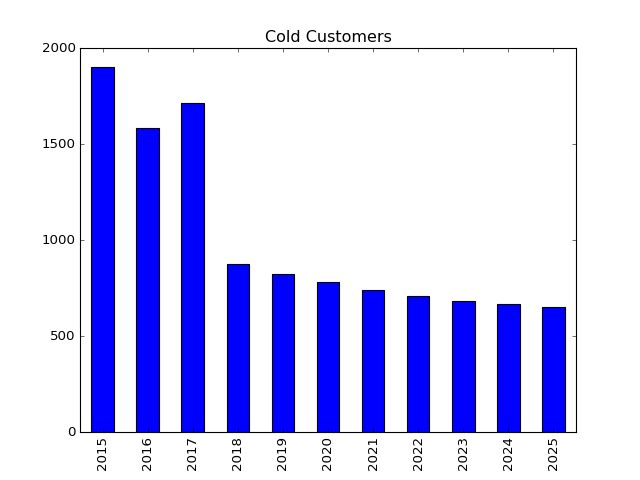

In [177]:
segments.loc['cold',:].plot.bar(title="Cold Customers")

<IPython.core.display.Javascript object>


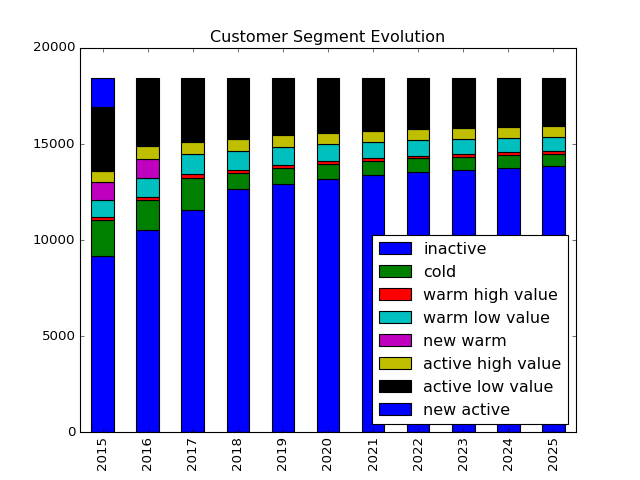

In [174]:
segments.T.plot.bar(stacked=True,title="Customer Segment Evolution")